# Лабораторна робота №2

## Розподіл роботи

Алгоритм Гафмана і LZW - Яремко Аня\
Алгоритм LZ77, Deflate і звіт - Еліосов Михайло

## Тестові функції

Рандомний розподіл літер

## Алгоритм Гафмана

In [44]:
class Node:
    '''
    A node class for the Huffman tree
    '''

    def __init__(self, frequency, letter=None, left=None, right=None):
        self.frequency = frequency
        self.letter = letter
        self.code = ''
        self.left = left
        self.right = right


class Huffman:
    '''
    Implements the Huffman algorithm
    '''

    def __init__(self):
        self.tree_root = None
        self.codes = {}

    def probabilities(self, text: str) -> list:
        '''
        Returns a list of leaf nodes
        '''
        probs = {}
        for symbol in text:
            if symbol not in probs:
                probs[symbol] = 1
            else:
                probs[symbol] += 1
        return sorted([Node(letter=letter, frequency=amount/len(text))
                       for letter, amount in probs.items()],
                      key=lambda node: node.frequency, reverse=True)

    def make_tree(self, probs) -> None:
        '''
        Makes a Huffman tree
        '''
        while len(probs) > 2:
            probs.sort(key=lambda node: node.frequency, reverse=True)
            first = probs[-1]
            second = probs[-2]
            probs = probs[:-2]
            probs.append(
                Node(frequency=first.frequency+second.frequency, left=first, right=second),)
        probs.sort(key=lambda node: node.frequency, reverse=True)
        first = probs[-1]
        second = probs[-2]
        self.tree_root = Node(frequency=first.frequency +
                              second.frequency, left=first, right=second)

    def create_codes(self, node: Node, code: str = '') -> None:
        '''
        Creates a codes dict for the given tree
        '''
        if node.left and node.right:
            self.create_codes(node.left, code+'0')
            self.create_codes(node.right, code+'1')
        else:
            self.codes[node.letter] = code
            node.code = code

    def encode(self, text: str) -> str:
        '''
        Encodes text
        '''
        self.tree_root = None
        self.codes = {}
        probs = self.probabilities(text)
        if len(probs) == 1:
            self.tree_root = probs[0]
            self.tree_root.code = '0'
            self.codes[self.tree_root.letter] = '0'
        else:
            self.make_tree(probs)
            self.create_codes(self.tree_root)
        code_table = text.maketrans(self.codes)
        return text.translate(code_table)

    def decode(self, code: str) -> str:
        '''
        Decodes a string
        '''
        decoded_text = ''
        node = self.tree_root
        for bit in code:
            if not (node.right and node.left):  # single letter string case
                decoded_text += node.letter
                node = self.tree_root
                continue
            if bit == '1':
                node = node.right
            else:
                node = node.left
            if not (node.right and node.left):
                decoded_text += node.letter
                node = self.tree_root
        return decoded_text

    def canonical_code(self):
        '''
        Returns the size of the dict as canonical codes
        '''
        size = 0
        for code in self.codes.values():
            size += len(bin(len(code))[2:])+len(str(code))
        return size


Приклад роботи:

In [45]:
with open('text.txt', 'r', encoding='utf-8') as file:
    data = file.read()
huffman = Huffman()
encoded = huffman.encode(data)
print('Original: ', len(data))
print('Compressed: ', len(encoded)/8+huffman.canonical_code())
print('Compression ratio: ', round(
    100*(len(encoded)/8+huffman.canonical_code())/len(data), 2), '%')
assert huffman.decode(encoded) == data


Original:  239632
Compressed:  135320.25
Compression ratio:  56.47 %


Найкраще застосовувати, коли є велика різниця у частоті символів

## Алгоритм LZW

In [46]:

class LZW:
    """
    Implements the LZW algotithm
    """

    def __init__(self):
        self.saver = {chr(i): i for i in range(256)}
        self.num = 256

    def encode(self, text: str) -> str:
        '''
        Compresses the information
        '''
        compressed_data = []
        number = 1
        cur_el = text[0]

        while number < len(text):
            if cur_el + text[number] in self.saver:
                cur_el = cur_el + text[number]
                number += 1
            else:
                compressed_data.append(self.saver[cur_el])
                self.saver[cur_el + text[number]] = self.num
                self.num += 1
                cur_el = text[number]
                number += 1
        compressed_data.append(self.saver[cur_el])
        return ' '.join([str(code) for code in compressed_data])

    def decode(self, code: str) -> str:
        '''
        Decompresses the compressed information
        '''
        new_saver = {value: key for key, value in self.saver.items()}
        decoded_text = ''
        for element in code.split(' '):
            decoded_text += new_saver[int(element)]
        return decoded_text


Приклад роботи:

In [47]:
with open('text.txt', 'r', encoding='utf-8') as file:
    data = file.read()
lzw = LZW()
encoded = lzw.encode(data)
print('Original: ', len(data))
print('Compressed: ', len(encoded))
print('Compression ratio: ', round(100*len(encoded)/len(data), 2), '%')
assert lzw.decode(encoded) == data


Original:  239632
Compressed:  291576
Compression ratio:  121.68 %


Найкраще застосовувати, коли дані часто повторюються

## Алгоритм LZ77

In [48]:
class LZ77:
    '''
    Implements the LZ77 algorithm'''

    def encode(self, text: str, window_length: int = 32768, max_offset: int = 255) -> list:
        '''
        Encodes the text as a list of tuples
        '''
        compressed_data = []
        window = ''
        while text:
            window = window[-window_length:]
            length, offset = 1, 0
            for i in range(min(len(window)-1, max_offset), -1, -1):
                if window[i] == text[0]:
                    found_length = self.repetition_length(
                        window[i:], text
                    )
                    if found_length > length:
                        offset = len(window)-i
                        length = found_length
            if offset == 0:
                compressed_data.append((0, 1, text[0]))
            else:
                compressed_data.append((offset, length, ''))
            window += text[:length]
            text = text[length:]
        return compressed_data

    def repetition_length(self, window, text):
        '''
        Finds how long the window repeats for
        '''
        length = 0
        while text:
            if window[0] == text[0]:
                length += 1
                window = window[1:] + text[0]
                text = text[1:]
            else:
                break
        return length

    def code_to_bytes(self, code: list) -> str:
        '''
        Compresses the code to bytes
        '''
        optimized_code = ''
        for offset, length, letter in code:
            if offset > 0:
                optimized_code += f'{offset}/{length}|'
            else:
                optimized_code += f'{letter}|'
        return optimized_code[:-1]

    def code_from_bytes(self, bytes_str: str) -> list:
        '''
        Compresses the code from bytes
        '''
        code = []
        for line in bytes_str.split('|'):
            if '/' not in line:
                if line == '':
                    if code[-1] != (0, 1, '|'):
                        code.append((0, 1, '|'))
                else:
                    code.append((0, 1, line))
            else:
                offset, length = line.split('/')
                if offset == '':
                    code.append((0, 1, '/'))
                else:
                    code.append((int(offset), int(length), ''))
        return code

    def decode(self, code: list) -> str:
        '''
        Decodes the text from a list of tuples
        '''
        decoded_text = ""
        index = 0
        for offset, length, letter in code:
            if offset == 0:
                index += 1
                decoded_text += letter
                continue
            while length > 0:
                decoded_text += decoded_text[index-offset]
                index += 1
                length -= 1
        return decoded_text


Приклад роботи (при стандартних параметрах):

In [49]:
lz77 = LZ77()
with open('text.txt', 'r', encoding='utf-8') as file:
    data = file.read()
encoded = lz77.encode(data)
encoded_compressed = lz77.code_to_bytes(encoded)
print('Original: ', len(data))
print('Compressed: ', len(encoded_compressed))
print('Compression ratio: ', round(100*len(encoded)/len(data), 2), '%')
assert lz77.decode(encoded) == data
assert lz77.decode(lz77.code_from_bytes(encoded_compressed)) == data


Original:  239632
Compressed:  678290
Compression ratio:  54.05 %


Приклад роботи (при максимальному стисненні):

In [50]:
lz77 = LZ77()
with open('text.txt', 'r', encoding='utf-8') as file:
    data = file.read()
encoded = lz77.encode(data, window_length=10**100, max_offset=10**100)
encoded_compressed = lz77.code_to_bytes(encoded)
print('Original: ', len(data))
print('Compressed: ', len(encoded_compressed))
print('Compression ratio: ', round(100*len(encoded)/len(data), 2), '%')
assert lz77.decode(encoded) == data
assert lz77.decode(lz77.code_from_bytes(encoded_compressed)) == data


Original:  239632
Compressed:  276930
Compression ratio:  15.56 %


Найкраще застосовувати, коли підстрічки часто повторюються

## Алгоритм Deflate

In [51]:

class Inflate:
    '''
    Implements Inflate and Deflate
    '''

    def __init__(self) -> None:
        self.huffman = None

    def encode(self, text: str) -> str:
        '''
        Encodes the data
        '''
        lz77 = LZ77()
        code = lz77.code_to_bytes(lz77.encode(text))
        self.huffman = Huffman()
        return self.huffman.encode(code)

    def decode(self, code: str) -> str:
        '''
        Decodes the data
        '''
        lz77 = LZ77()
        lz77_code = self.huffman.decode(code)
        return lz77.decode(lz77.code_from_bytes(lz77_code))


Приклад роботи (примітка: для ефективного стиснення потрібен значно складніша реалізація кодування Гафманом)

In [52]:
with open('text.txt', 'r', encoding='utf-8') as file:
    data = file.read()
inflate = Inflate()
encoded = inflate.encode(data)
print('Original: ', len(data))
print('Compressed: ', len(encoded)/8+inflate.huffman.canonical_code())
print('Compression ratio: ', round(
    100*(len(encoded)/8+inflate.huffman.canonical_code())/len(data), 2), '%')
assert inflate.decode(encoded) == data


Original:  239632
Compressed:  321967.125
Compression ratio:  134.36 %


Найкраще застосовувати, коли підстрічки часто повторюються (так само як і LZ77)

## Оцінка швидкості

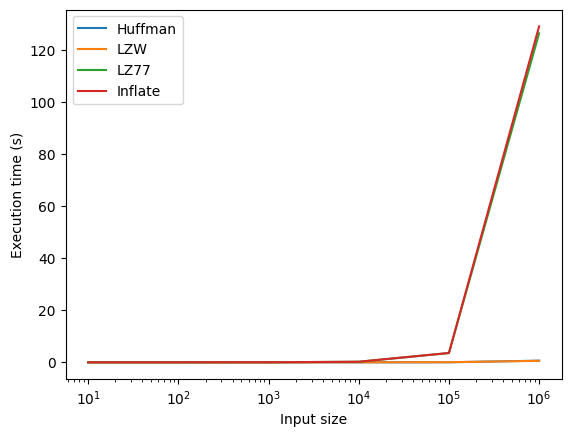

In [60]:

import time
import random
import matplotlib.pyplot as plt
from huffman import Huffman
from lz77 import LZ77
from lzw import LZW

# initialize Huffman and LZW classes
huffman = Huffman()
lzw = LZW()
lz77 = LZ77()
inflate = Inflate()

input_sizes = [10**i for i in range(1, 7)]

huffman_times = []
lzw_times = []
lz77_times = []
inflate_times = []


def generate_string(length: int) -> str:
    '''
    Generates a string for testing
    '''
    return ''.join(random.choice('abcdefghijklmnopqrstuvwxyz') for _ in range(length))


for size in input_sizes:
    input_string = generate_string(size)

    start_time = time.time()
    huffman.encode(input_string)
    huffman_times.append(time.time() - start_time)

    start_time = time.time()
    lzw.encode(input_string)
    lzw_times.append(time.time() - start_time)

    start_time = time.time()
    lz77.code_to_bytes(lz77.encode(input_string))
    lz77_times.append(time.time() - start_time)

    start_time = time.time()
    inflate.encode(input_string)
    inflate_times.append(time.time() - start_time)

plt.plot(input_sizes, huffman_times, label='Huffman')
plt.plot(input_sizes, lzw_times, label='LZW')
plt.plot(input_sizes, lz77_times, label='LZ77')
plt.plot(input_sizes, inflate_times, label='Inflate')
plt.xscale('log')
plt.xlabel('Input size')
plt.ylabel('Execution time (s)')
plt.legend()
plt.show()


## Висновок

Найкраще застовувати:

Гафмана - коли є кілька символів, які повторюються значно частіше решти\
LZ77 - коли є багато повторень підстрічок\
Deflate - аналогічно до LZ77\
LZW - коли не виконується жодна з цих умов